In [1]:
# %load_ext autoreload
# %autoreload 2
    
%matplotlib inline
import sys
import numpy as np
from scipy import signal, optimize
import matplotlib.pyplot as plt
from fooof import FOOOFGroup
from neurodsp import sim, spectral
from seaborn import despine
import brian2 as b2

sys.path.append('../')
import echo_utils

font = {'family' : 'arial',
        'weight' : 'regular',
        'size'   : 14}
plt.rc('font', **font)

fig_path = '../figures/sim/%s.pdf'
save_plot=True



********************************************************************************
         to build the TVTK classes (8.2). This may cause problems.
         Please rebuild TVTK.
********************************************************************************



In [85]:
fs = 2000.
# t_sim = 2.
# t_ker = np.arange(0,t_sim,1/fs)
# t_r = 0
t_ds = np.arange(0.005,0.08,0.01)
f_to_plot=200
# kernels = []

# simulate noise
T = 180
noise, ac = [], []
for t_d in t_ds:
    noise.append(sim.sim_synaptic_current(T, fs, tau_d = t_d))
    ac.append(signal.correlate(noise[-1], noise[-1])[int(T*fs)-1:])

noise = np.vstack(noise)
ac = np.vstack(ac).T

f_axis, PSD = spectral.compute_spectrum(noise,fs)

# FOOOF PSDs without knee
fg = FOOOFGroup(aperiodic_mode='knee', max_n_peaks=0)
fg.fit(freqs=f_axis, power_spectra=PSD, freq_range=(2,200))
fit_knee = fg.get_params('aperiodic_params', 'knee')
fit_exp = fg.get_params('aperiodic_params', 'exponent')
knee_freq, taus = echo_utils.convert_knee_val(fit_knee, fit_exp)
P_knee = [PSD[i,np.argmin(np.abs((f_axis[:f_to_plot]-(knee_freq[i]))))] for i in range(len(t_ds))]

Running FOOOFGroup across 8 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



# Autocorrelation of Additive Independent Noise

In [3]:
add_noise = noise[0]+noise[-1]
ac_combined = signal.correlate(add_noise, add_noise)[int(T*fs)-1:]
f_axis, PSD_combined = spectral.compute_spectrum(add_noise,fs)

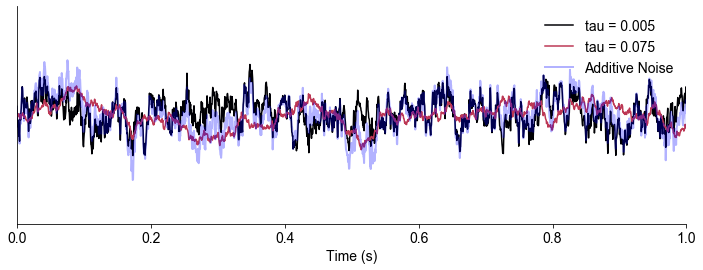

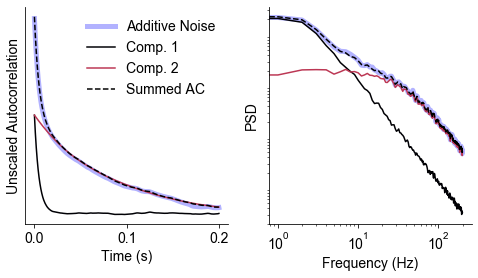

In [4]:
color = plt.cm.inferno(np.linspace(0,1,3))
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', color)

t = np.arange(0,T,1/fs)
plt.figure(figsize=(12,4))
plt.plot(t, noise[0], label='tau = %.3f'%t_ds[0])
plt.plot(t, noise[-1], label='tau = %.3f'%t_ds[-1])
plt.plot(t, add_noise, 'b', lw=2, alpha=0.3, label='Additive Noise')
plt.legend(frameon=False, loc='upper right')
plt.xlabel('Time (s)'); plt.yticks([]); plt.xlim([0, 1]); despine()

t_plot = 400
t_ac = np.arange(0,t_plot)/fs
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(t_ac, ac_combined[:t_plot], 'b', lw=5, alpha=0.3, label='Additive Noise')
plt.plot(t_ac,ac[:t_plot, 0], label='Comp. 1')
plt.plot(t_ac,ac[:t_plot, -1], label='Comp. 2')
plt.plot(t_ac,ac[:t_plot, -1]+ac[:t_plot, 0], 'k--', label='Summed AC')
plt.xlabel('Time (s)'); plt.ylabel('Unscaled Autocorrelation'); plt.yticks([]); plt.legend(frameon=False)
despine()

plt.subplot(1,2,2)
plt.loglog(f_axis[:f_to_plot], PSD_combined[:f_to_plot], 'b', lw=5, alpha=0.3)
plt.loglog(f_axis[:f_to_plot], PSD[-1][:f_to_plot])
plt.loglog(f_axis[:f_to_plot], PSD[0][:f_to_plot])
plt.plot(f_axis[:f_to_plot], PSD[0][:f_to_plot]+PSD[-1][:f_to_plot], 'k--')
plt.xlabel('Frequency (Hz)'); plt.ylabel('PSD'); plt.yticks([])
despine()

### Autocorrelation of Sum of Uncorrelated Noise is Additive
Probably could've Googled this but here it is. The challenge will probably be fitting the model well.

In [50]:
def exp2_func(t, tau1, tau2, k1, k2):
    return k1*np.exp(-t/tau1) + k2*np.exp(-t/tau2)

def exp1_func(t, tau1, k1):
    return k1*np.exp(-t/tau1)

def explong_func(t, tau, A, B):
    return A*(np.exp(-t/tau1)+B)

[0.05993784 0.63798691]
[0.00496741 0.07789567 0.50663228 0.49379968]


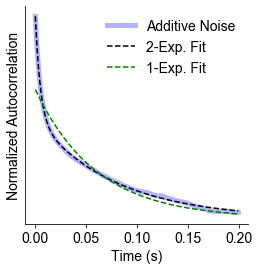

In [7]:
ac_norm = ac_combined[:t_plot]/ac_combined[0]

param_bounds1 =([0, 0], [10, np.inf])
param_bounds2 =([0, 0, 0, 0], [10, 10, np.inf, np.inf])

p1e = optimize.curve_fit(exp1_func, t_ac, ac_norm, bounds = param_bounds1)[0]
p2e = optimize.curve_fit(exp2_func, t_ac, ac_norm, bounds = param_bounds2)[0]

ac_ex = exp2_func(t_ac, p2e[0], p2e[1], p2e[2], p2e[3])

plt.figure(figsize=(4,4))
plt.plot(t_ac, ac_norm, 'b', lw=5, alpha=0.3, label='Additive Noise')
plt.plot(t_ac, exp2_func(t_ac, p2e[0], p2e[1], p2e[2], p2e[3]), '--', label='2-Exp. Fit')
plt.plot(t_ac, exp1_func(t_ac, p1e[0], p1e[1]), '--g', label='1-Exp. Fit')
plt.ylabel('Normalized Autocorrelation'); plt.yticks([]); plt.xlabel('Time (s)'); plt.legend(frameon=False)

print(p1e)
print(p2e)
despine()

---
# Simulating Timescale Separation of LFP and Spiking
Possibe parameters to tune:

Single neuron:
- time constant of noise input (white vs. colored)
- membrane time constant / synaptic time constant
- do the same with membrane fluctuations

Network of neurons:
- correlation structure of input
- connectivity
- cell-types

In [2]:
from brian2 import *

In [117]:
start_scope()
T_sim = 50.2

# neuron parameters
taum = 20*ms
Vt = -30*mV
Vr = -60*mV
El = -50*mV

# synapse parameters
we = 1*mV # excitatory synaptic weight (voltage)
taue = 25*ms

# define neuron equation
eqs = '''
dv/dt  = (ge-(v-El))/taum : volt (unless refractory)
dge/dt = -ge/taue : volt
'''

# initialize neuron
P = NeuronGroup(1, eqs, threshold='v>Vt', reset='v = Vr', refractory=5*ms, method='exact')
#P.v = 'Vr + rand() * (Vt - Vr)'
P.v = 'Vr'
P.ge = 0*mV

# initialize input
P_input = PoissonGroup(400, 10*Hz)

# initialize & connect synapses
S = Synapses(P_input, P, on_pre='ge += we')
S.connect()

# run 
fs = 1000
s_mon = SpikeMonitor(P)
v_mon = StateMonitor(P, ['v', 'ge'], dt=(1/fs)*second, record=True)
run(T_sim * second)
print('Done.')

Done.


(0, 1)

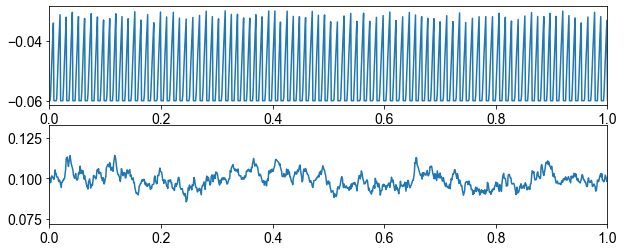

In [136]:
t_burn = 0.2 # 200ms of throw-away
burn_in = int(t_burn*fs) 
t = np.array(v_mon.t[burn_in:]) - t_burn
vm = np.array(v_mon.v[0][burn_in:])
ge = np.array(v_mon.ge[0][burn_in:])
st = np.array(s_mon.t[np.array(s_mon.t)>=t_burn])-t_burn

plt.figure(figsize=(10,4))
plt.subplot(2,1,1)
plt.plot(t, vm)
plt.xlim([0,1])
plt.subplot(2,1,2)
plt.plot(t, ge)
plt.xlim([0,1])
# plot(s_mon.t/ms, s_mon.i, ',k')
# xlabel('Time (ms)')
# ylabel('Neuron index')
# show()


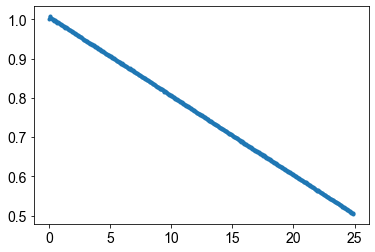

In [169]:
# discretize spikes
del_t = 0.05 # 50ms as in Murray 2014
t_bins = np.arange(0, T_sim-t_burn, del_t)
sc = np.histogram(st, t_bins)[0]
# acg
acg = np.correlate(sc, sc, mode='same')[int(len(binned_spks)/2):]
acg = acg/acg[0]
plt.plot(t_bins[:len(acg)], acg, '.-')
#plt.xlim([0,1])

In [172]:
sp.xcorr()

NameError: name 'sp' is not defined

Running FOOOFGroup across 1 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



array([0.02636172])

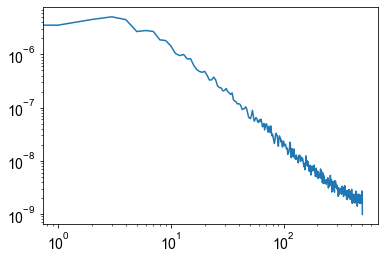

In [170]:
fs = 1000
f_axis, PSD_syn = spectral.compute_spectrum(v_mon.ge[0], fs)
plt.loglog(f_axis, PSD_syn)

fg = FOOOFGroup(aperiodic_mode='knee', max_n_peaks=0)
fg.fit(freqs=f_axis, power_spectra=PSD_syn[None,:], freq_range=(1,100))
fit_knee = fg.get_params('aperiodic_params', 'knee')
fit_exp = fg.get_params('aperiodic_params', 'exponent')
knee_freq, taus = echo_utils.convert_knee_val(fit_knee, fit_exp)
taus

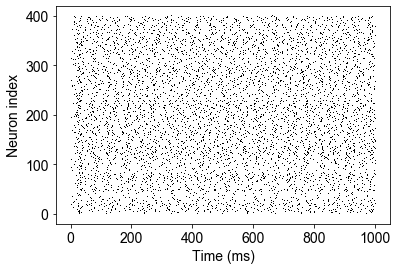

In [9]:
start_scope()

taum = 20*ms
taue = 5*ms
taui = 10*ms
Vt = -50*mV
Vr = -60*mV
El = -49*mV

eqs = '''
dv/dt  = (ge+gi-(v-El))/taum : volt (unless refractory)
dge/dt = -ge/taue : volt
dgi/dt = -gi/taui : volt
'''

P = NeuronGroup(400, eqs, threshold='v>Vt', reset='v = Vr', refractory=5*ms,
                method='exact')
P.v = 'Vr + rand() * (Vt - Vr)'
P.ge = 0*mV
P.gi = 0*mV

we = (60*0.27/10)*mV # excitatory synaptic weight (voltage)
wi = (-20*4.5/10)*mV # inhibitory synaptic weight
Ce = Synapses(P, P, on_pre='ge += we')
Ci = Synapses(P, P, on_pre='gi += wi')
Ce.connect('i<320', p=0.02)
Ci.connect('i>=320', p=0.02)

s_mon = SpikeMonitor(P)

run(1 * second)

plot(s_mon.t/ms, s_mon.i, ',k')
xlabel('Time (ms)')
ylabel('Neuron index')
show()


nr of spikes: 0


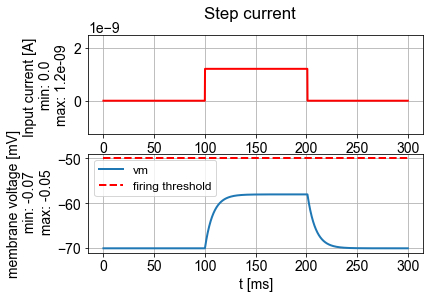

nr of spikes: 5


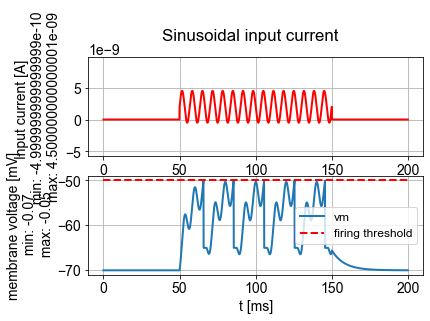

Resting potential: -0.07
Reset voltage: -0.065
Firing threshold: -0.05
Membrane resistance: 10000000.0
Membrane time-scale: 0.008
Absolute refractory period: 0.002


In [6]:
import brian2 as b2
from neurodynex.leaky_integrate_and_fire import LIF

from neurodynex.tools import input_factory, plot_tools


LIF.getting_started()
LIF.print_default_parameters()